In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [2]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from statsmodels.tools.tools import add_constant

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
%%bash
# (70s)
mkdir ./modeling

echo "2*0.6 10*1 25*0.4 35*1.2 45*0.2" > ./modeling/timingsAM.1D

echo "2 10 25 35 45" > ./modeling/timings.1D

3dDeconvolve -overwrite -x1D_stop -polort -1 -nodata 48 1.25 \
    -num_stimts 1 \
    -stim_times_AM1 1 ./modeling/timingsAM.1D 'TWOGAMpw(3,6,0.2,10,12,1)' \
    -x1D ./modeling/data.1D


3dDeconvolve -overwrite -x1D_stop -polort -1 -nodata 48 1.25 \
    -num_stimts 1 \
    -stim_times 1 ./modeling/timings.1D 'TWOGAMpw(3,6,0.2,10,12,1)' \
    -x1D ./modeling/clm_regressor.1D


3dDeconvolve -overwrite -x1D_stop -polort -1 -nodata 48 1.25 \
    -num_stimts 1 \
    -stim_times_IM 1 ./modeling/timings.1D 'TWOGAMpw(3,6,0.2,10,12,1)' \
    -x1D ./modeling/tlm_regressor.1D

mkdir: cannot create directory ‘./modeling’: File exists
++ '-stim_times_AM1 1 ./modeling/timingsAM.1D' has 1 auxiliary values per time point
++ GAM conversion: peak=3 fwhm=6 -> p=1.46087 q=2.05357
++ GAM conversion: peak=10 fwhm=12 -> p=3.92693 q=2.54652
++ waveform setup: TWOGAM()
*+ WARNING: no -stim_label given for stim #1 ==> label = 'Stim#1'
++ 3dDeconvolve: AFNI version=AFNI_20.1.00 (Apr  9 2020) [64-bit]
++ Authored by: B. Douglas Ward, et al.
++ using TR=1.25 seconds for -stim_times and -nodata
++ using NT=48 time points for -nodata
++ -stim_times using TR=1.25 s for stimulus timing conversion
++ -stim_times using TR=1.25 s for any -iresp output datasets
++  [you can alter the -iresp TR via the -TR_times option]
++ ** -stim_times NOTE ** guessing GLOBAL times if 1 time per line; LOCAL otherwise
++ ** GUESSED ** -stim_times_AM1 1 using LOCAL times
++ '-stim_times_AM1 1' average amplitude#1=0.68
++ Number of time points: 48 (no censoring)
 + Number of parameters:  1 [0 baseline 

In [4]:
clm_reg = np.loadtxt('./modeling/clm_regressor.1D')
tlm_reg = np.loadtxt('./modeling/tlm_regressor.1D')

In [5]:
np.random.seed(42)
noise = np.random.normal(0,0.2,clm_reg.size)
raw = np.loadtxt('./modeling/data.1D') + noise

# 1. Condition Level Modeling (CLM) vs. Trial Level Modeling (TLM)

Consider the following raw timeseries data which contains 7 events. 

The peaks for 7 events are not very evident due to random noise in the data.

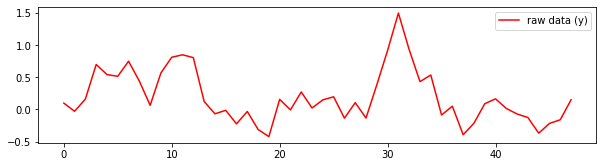

In [6]:
plt.figure(figsize=(10,2.5))
plt.plot(raw,color='red',label='raw data (y)')
plt.legend()

## 1.1. CLM

Conventional approach to model the responses is to specify a single regressor for a condition.

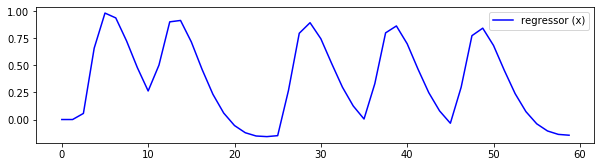

In [10]:
plt.figure(figsize=(10,2.5))
plt.plot(time,clm_reg,color='blue',label='regressor (x)')
plt.legend()

In [9]:
time

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47])

Notice all peaks have the same amplitude (= 1).

Now $x$ can be regressed on to the raw data ($y$) by running a simple linear regression model.

$$\hat{y^{(i)}} = \beta_{0} + \beta_{x}x^{(i)}$$

Where $\hat{y^{(i)}}$ is estimated response for the $i$th timepoint.


In [8]:
lm_clm = LinearRegression()
X_clm = add_constant(clm_reg)
lm_clm.fit(X_clm,raw)
y_hat_clm = lm_clm.predict(X_clm)

Following shows the estimated response ($\hat{y}$) overlaid in the raw data ($y$).

Notice the amplitude of all peaks in $\hat{y}$ is the same, however now scaled down to 0.64 from 1 (because it happens to provide the best average fit).  

The 0.64 is the scaling factor ($\beta_{x}$ in the equation above) for the regressor $x$.


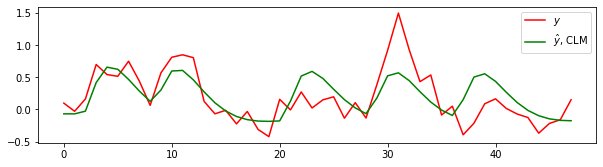

In [9]:
plt.figure(figsize=(10,2.5))
plt.plot(raw,color='red',label='$y$')
plt.plot(y_hat_clm,color='green',label=r'$\hat{y}$, CLM')
plt.legend()

## 1.2. TLM

Now lets model the response at trial level. Each event will be modele by a separate regressors.

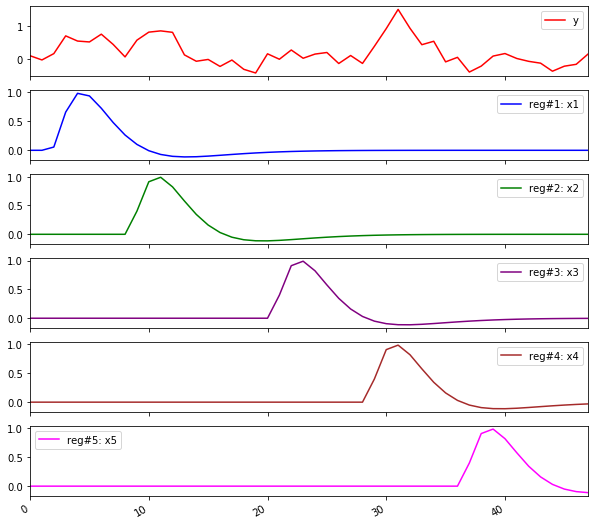

In [11]:
_=pd.DataFrame(np.hstack((raw[:,None],tlm_reg)),
               columns=['y']+['reg#%i: x%i' %(i,i) for i in range(1,6)]).plot(subplots=True,
                                                                       color=['red','blue','green','purple','brown','magenta','cyan','black'],
                                                                       figsize=(10,10))

Notice again, peaks of all 7 regressors have the same amplitude (= 1).

The $x_{k}$ (where $k$ = 1,2,..n; n is total number of regressors) can be regressed on to the raw data ($y$) by running a multiple linear regression model.

$$\hat{y^{(i)}} = \beta_{0} + \sum^{n}_{k = 1}{\beta_{x_{k}}x^{(i)}_{k}}$$

Where $\hat{y^{(i)}}$ is estimated response for $i$th timepoint.

In [12]:
lm_tlm = LinearRegression()
X_tlm = add_constant(tlm_reg)
lm_tlm.fit(X_tlm,raw)
y_hat_tlm = lm_tlm.predict(X_tlm)

Notice the peaks in $\hat{y}$ have acquired different amplitudes in order to approximate the raw data.  

That is, each regressor is now scaled by a different $\beta_{x_{k}}$, where k = 1,2,..,n.

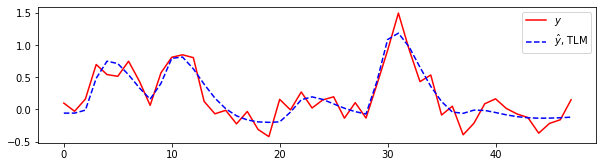

In [15]:
plt.figure(figsize=(10,2.5))
plt.plot(raw,color='red',label='$y$')
plt.plot(y_hat_tlm,color='blue',label=r'$\hat{y}$, TLM',linestyle='--')
#plt.legend(loc='upper left',bbox_to_anchor=[1,0.75])
plt.legend()

## 1.3. Visualize fits from both methods

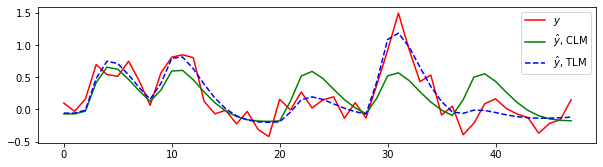

In [16]:
plt.figure(figsize=(10,2.5))
plt.plot(raw,color='red',label='$y$')
plt.plot(y_hat_clm,color='green',label=r'$\hat{y}$, CLM')
plt.plot(y_hat_tlm,color='blue',label=r'$\hat{y}$, TLM',linestyle='--')
#plt.legend(loc='upper left',bbox_to_anchor=[1,0.75])
plt.legend()

In [ ]:
pd.DataFrame(np.hstack([raw,clm_reg,y_hat_clm,tlm_reg,y_hat_tlm])

In [54]:
tlm_reg.shape

(48, 5)

In [65]:
df = pd.DataFrame(np.hstack([np.stack([raw,clm_reg,y_hat_clm,y_hat_tlm]).T,tlm_reg]),columns=['EPI',                                                                                    'TLMReg5'])

In [69]:
#df.to_csv('plotting_data.csv',sep=',',index=False)

In [3]:
%%bash
# (70s)
mkdir ./modeling

#echo "2*2:0.3544 10*2:0.31724 25*3:1.14137 35*3:0.71425 45*4:0.51022" > ./modeling/AM1.1D
echo "2*2:1 10*2:1 25*3:1 35*3:1 45*4:1" > ./modeling/AM1.1D

3dDeconvolve -overwrite -x1D_stop -polort -1 -nodata 48 1.25 \
    -num_stimts 1 \
    -stim_times_AM2 1 ./modeling/AM1.1D 'dmBLOCK' \
    -x1D ./modeling/AM1_regs_mc.1D

mkdir: cannot create directory ‘./modeling’: File exists
++ '-stim_times_AM2 1 ./modeling/AM1.1D' has 2 auxiliary values per time point
++ '-stim_times_AM2 1': basis function model 'dmBLOCK' uses 1 parameters,
    out of the 2 found in timing file './modeling/AM1.1D'
++ '-stim_times_AM2 1 ./modeling/AM1.1D' will have 2 regressors
*+ WARNING: no -stim_label given for stim #1 ==> label = 'Stim#1'
++ 3dDeconvolve: AFNI version=AFNI_20.1.00 (Apr  9 2020) [64-bit]
++ Authored by: B. Douglas Ward, et al.
++ using TR=1.25 seconds for -stim_times and -nodata
++ using NT=48 time points for -nodata
++ -stim_times using TR=1.25 s for stimulus timing conversion
++ -stim_times using TR=1.25 s for any -iresp output datasets
++  [you can alter the -iresp TR via the -TR_times option]
++ ** -stim_times NOTE ** guessing GLOBAL times if 1 time per line; LOCAL otherwise
++ ** GUESSED ** -stim_times_AM2 1 using LOCAL times
++ '-stim_times_AM2 1' average amplitude#1=2.8
++ Number of time points: 48 (no cens

In [4]:
%%bash

AFNI_3dDeconvolve_rawAM2 to YES

3dDeconvolve -overwrite -x1D_stop -polort -1 -nodata 48 1.25 \
    -num_stimts 1 \
    -stim_times_AM2 1 ./modeling/AM1.1D 'dmBLOCK' :0.000001 \
    -x1D ./modeling/AM1_regs.1D

bash: line 2: AFNI_3dDeconvolve_rawAM2: command not found
++ '-stim_times_AM2 1 ./modeling/AM1.1D' has 2 auxiliary values per time point
++ '-stim_times_AM2 1': basis function model 'dmBLOCK' uses 1 parameters,
    out of the 2 found in timing file './modeling/AM1.1D'
++ '-stim_times_AM2 1 ./modeling/AM1.1D' has modulation parameter centering string ' 0.000001'
 + '-stim_times_AM2 1 ./modeling/AM1.1D' will subtract 1e-06 from input modulation parameter #1
++ '-stim_times_AM2 1 dmBLOCK' will have 2 regressors
*+ WARNING: no -stim_label given for stim #1 ==> label = 'Stim#1'
++ 3dDeconvolve: AFNI version=AFNI_20.1.00 (Apr  9 2020) [64-bit]
++ Authored by: B. Douglas Ward, et al.
++ using TR=1.25 seconds for -stim_times and -nodata
++ using NT=48 time points for -nodata
++ -stim_times using TR=1.25 s for stimulus timing conversion
++ -stim_times using TR=1.25 s for any -iresp output datasets
++  [you can alter the -iresp TR via the -TR_times option]
++ ** -stim_times NOTE ** guessing GLOB

In [5]:
regs = pd.DataFrame(np.hstack([np.loadtxt('modeling/AM1_regs_mc.1D'),np.loadtxt('modeling/AM1_regs.1D')]),columns=['shock','button_press_mc','shock1','button_press'])
regs = regs[['shock','button_press','button_press_mc']]

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

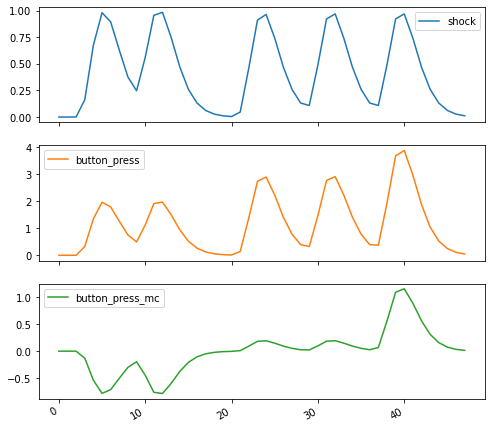

In [6]:
regs.plot(subplots=True,figsize=(8,8))

<AxesSubplot:>

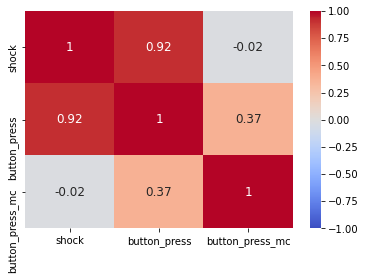

In [7]:
import seaborn as sns
sns.heatmap(regs.corr(),vmin=-1,vmax=1,cmap='coolwarm',annot=True,annot_kws=dict(size=12),)